<a href="https://colab.research.google.com/github/yuliaplaksina/Machine-learning/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 лабораторная

## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve

In [2]:
import io
from google.colab import files
data = files.upload()

In [3]:
data = pd.read_csv('heart.csv', sep=",")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Проверим, есть ли в наборе данных путсые значения

In [4]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Вынесем из общей таблицы целевой признак

In [5]:
X = data.loc[:, data.columns != 'target']
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [6]:
Y = data['target']
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

1. Разделим выборку на тренировочную и тестовую 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=1)

In [8]:
#Размер тренировочной выборки
X_train.shape, y_train.shape

((227, 13), (227,))

In [9]:
#Размер тестовой выборки
X_test.shape, y_test.shape

((76, 13), (76,))

In [10]:
#Будем изучать метод с использованием 4 ближайших соседей
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
predicted

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

Выберем метрики: recall, f1, accuracy

Найдем показатели метрик для KNN при k=4

In [11]:
classification_report(y_test, predicted, output_dict=True)["0"], \
classification_report(y_test, predicted, output_dict=True)["1"]

({'f1-score': 0.5526315789473684,
  'precision': 0.5121951219512195,
  'recall': 0.6,
  'support': 35},
 {'f1-score': 0.5526315789473684,
  'precision': 0.6,
  'recall': 0.5121951219512195,
  'support': 41})

При помощи решетчатого поиска и кросс-валидации найдем оптимальное значение гиперпараметра k

In [12]:
scoring = {
    'recall': make_scorer(recall_score), 
    'f1': make_scorer(f1_score), 
    'accuracy': make_scorer(accuracy_score)
}
n_range = np.array(range(1,60,3))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
         52, 55, 58])}]

In [13]:
knn_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=scoring, refit='f1')
knn_gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58])}],
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score)},
             verbose=0)

In [14]:
knn_gs.cv_results_

{'mean_fit_time': array([0.0026494 , 0.00238152, 0.00241361, 0.00253181, 0.00258365,
        0.00249505, 0.00234251, 0.00235982, 0.00242777, 0.00234704,
        0.00236511, 0.00231533, 0.00229988, 0.00243683, 0.00260353,
        0.00248923, 0.00248199, 0.00242491, 0.00240417, 0.00268402]),
 'mean_score_time': array([0.01002297, 0.00983138, 0.01052647, 0.01026292, 0.01055131,
        0.01066027, 0.00996351, 0.01007023, 0.01006899, 0.01011801,
        0.01049657, 0.01075163, 0.01030607, 0.01080842, 0.01086588,
        0.01109076, 0.01106882, 0.01075764, 0.01077271, 0.01122346]),
 'mean_test_accuracy': array([0.65198238, 0.65638767, 0.66079295, 0.62555066, 0.64317181,
        0.62995595, 0.65198238, 0.65198238, 0.63876652, 0.63876652,
        0.64757709, 0.61674009, 0.62555066, 0.62995595, 0.60792952,
        0.62555066, 0.62995595, 0.63436123, 0.61674009, 0.62114537]),
 'mean_test_f1': array([0.70050587, 0.65329071, 0.69881713, 0.65535432, 0.69413948,
        0.6680495 , 0.70212747, 0.69

Лучшая модель:

In [15]:

best_knn = knn_gs.best_estimator_
best_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

Лучшее значение f1

In [16]:
knn_gs.best_score_

0.7052798625001468

Лучшее значение k

In [17]:
knn_gs.best_params_

{'n_neighbors': 31}


На начальном разбиении проверим метрики при новом значении k

In [18]:
best_knn.fit(X_train, y_train)
predicted_best = knn.predict(X_test)
predicted_best

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [19]:
classification_report(y_test, predicted_best, output_dict=True)["0"], \
classification_report(y_test, predicted_best, output_dict=True)["1"]

({'f1-score': 0.5526315789473684,
  'precision': 0.5121951219512195,
  'recall': 0.6,
  'support': 35},
 {'f1-score': 0.5526315789473684,
  'precision': 0.6,
  'recall': 0.5121951219512195,
  'support': 41})

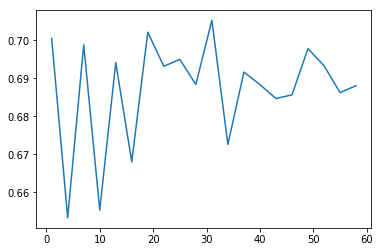

In [20]:
# изменение f1 от параметра k
plt.plot(n_range, knn_gs.cv_results_['mean_test_f1'])

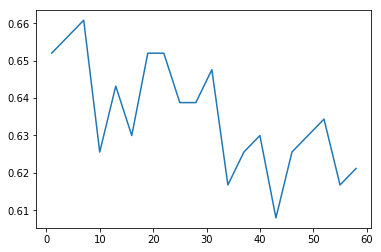

In [21]:
# изменение accuracy от параметра k
plt.plot(n_range, knn_gs.cv_results_['mean_test_accuracy'])

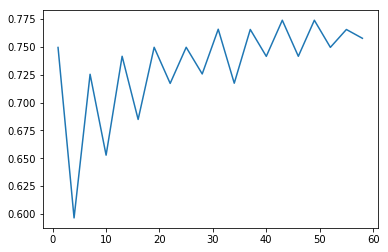

In [22]:
# изменение recall от параметра k
plt.plot(n_range, knn_gs.cv_results_['mean_test_recall'])

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

Кривые обучения и валидации

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

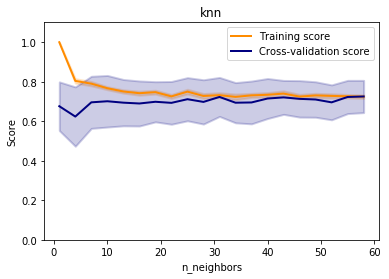

In [24]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=20, scoring="f1")

К=31 не особо видно на данном графике, поэтому приведем другой график

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

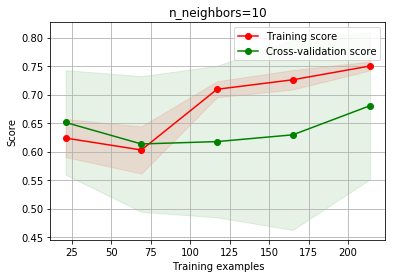

In [25]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=10), 'n_neighbors=10', 
                    X_train, y_train, cv=20)

Действительно, как мы можем видеть, значения при k=31 правктически сходятся в одну точку